In [1]:
import os
import cv2
import gc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import albumentations as A
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Leitura dos dados e divisão treino/teste

Antes de começarmos, vale ressaltar que o link fornecido no arquivo PDF prova não contém os rótulos da base. Eles podem ser encontrados [aqui](https://github.com/BotechEngineering/StanfordCarsDatasetCSV/tree/main).

A base Standof Cars já possui seus dados divididos  em conjuntos de treinamento e teste. A divisão é, praticamente de 50%-50%. Os dados de teste não estão rotulados por classe. Então, usaremos apenas os dados de treinamento em nossos experimentos.

In [2]:
train_labels = pd.read_csv("data/cardatasettrain.csv")
train_labels.drop(columns=[train_labels.columns[0]], inplace=True)
train_labels

,x1,y1,x2,y2,Class,image
0,39,116,569,375,14,00001.jpg
1,36,116,868,587,3,00002.jpg
2,85,109,601,381,91,00003.jpg
3,621,393,1484,1096,134,00004.jpg
4,14,36,133,99,106,00005.jpg
...,...,...,...,...,...,...
8139,3,44,423,336,78,08140.jpg
8140,138,150,706,523,196,08141.jpg
8141,26,246,660,449,163,08142.jpg
8142,78,526,1489,908,112,08143.jpg


Definindo as classes importantes

In [3]:
important_classes = [3,4,5]

Definindo o diretório raiz

In [4]:
train_image_root = 'data/cars_train/cars_train/'

Aqui, vamos adicionar as imagens ao conjunto de treinamento. 

In [5]:
train_data = [] #lista de imagens
classes1 = [] #lista de classes das imagens de train_data


In [6]:
for index, row in train_labels.iterrows():
    img = cv2.imread(f"{train_image_root}{row['image']}", cv2.COLOR_BGR2RGB)
    train_data.append(img)
    classes1.append(row['Class'])

Divisão treino e teste, conforme especificado na atividade. 

In [7]:
x_train, x_test, y_train, y_test = train_test_split(train_data, classes1, test_size=0.3, stratify=classes1, random_state=1)

In [8]:
print("Tamanho do conjunto de treinamento", len(x_train))
print("Tamanho do conjunto de teste", len(x_test))

Tamanho do conjunto de treinamento 5700
Tamanho do conjunto de teste 2444


As classes que não fazem parte da lista `important_classes` receberão o rótulo de 'indefinida'.

In [9]:
for i in range(len(y_train)):
    if y_train[i] not in important_classes:
        y_train[i] = 'indefinida'

for i in range(len(y_test)):
    if y_test[i] not in important_classes:
        y_test[i] = 'indefinida'

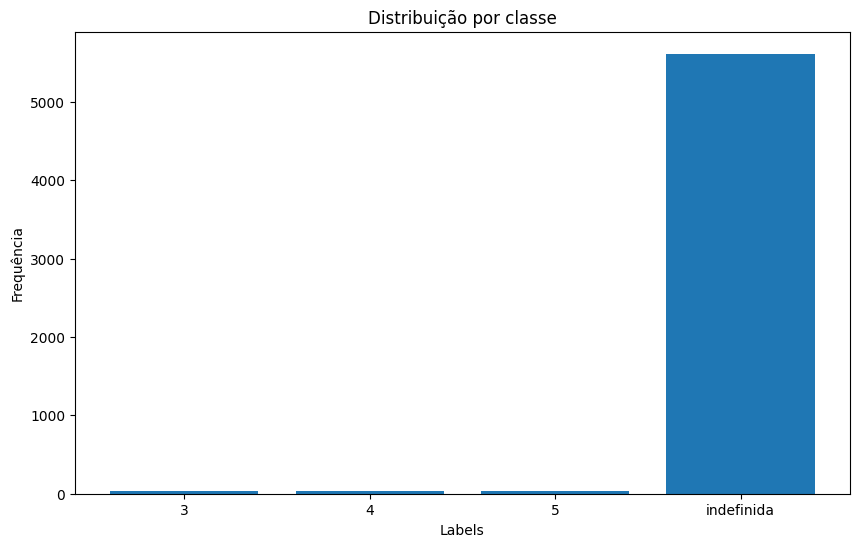

In [10]:
labels, counts = np.unique(np.array(y_train), return_counts=True)
labels = [str(i) for i in labels]

plt.figure(figsize=(10, 6))
plt.bar(labels, counts)
plt.xlabel('Labels')
plt.ylabel('Frequência')
plt.title('Distribuição por classe')
plt.show()

Observe na imagem acima, que há um enorme desbalanceamento entre as classes. Isso é natural, já que rotulamos 193 classes como 'indefinida'. Precisaremos de um processo robusto para lidarmos com esse conjunto de dados.

In [11]:
# Removemdo variáveis desnecessárias
del train_data, classes1
gc.collect()

3036

# Preprocessamento

Aqui, vamos definir um processo de data augmentation. Esse processo vai nos ajudar a aumentar a quantidade de amostras das classes não majoritárias, reduzindo o desbalanceamento.

As imagens que vão sofrer aumento vão passar por um processo seguindo o pipeline:
* Rotação horizontal;
* Ajuste do brilho e contraste;
* Redimensionamento aleatório de escala entre 0% e 5%;
* Recorte aleatório de uma região da imagem;
* Redimensionamento para (224, 224), padrão dos modelos do ImageNet;
* Normalização.

Optamos por manter as imagens originais no conjunto de treinamento (não apenas as versões aumentadas). Essas imagens passarão apenas por um processo de redimensionamento e normalização (`basic_process`).

In [12]:
def basic_process(img):
    # Média e desvio padrão do ImageNet (usaremos para normalização)
    imagenet_mean = [0.485, 0.456, 0.406]
    imagenet_std = [0.229, 0.224, 0.225]

    # Vamos garantir que todas as imagens tenham 3 canis
    if len(img.shape) == 2:  # grayscale para RGB
        img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    elif img.shape[2] == 1:  # único canal para RGB
        img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    else:
        img_rgb = img  # Caso a imagem já seja RGB

    # Redimensionar a imgem original para 224x224 (padrão do ImageNet)
    img_rgb = cv2.resize(img_rgb, (224, 224))

    # Normalizar as imagens originais para o formato ImageNet
    img_rgb = img_rgb / 255.0  # Scale to [0, 1] range
    img_rgb = (img_rgb - imagenet_mean) / imagenet_std

    return img_rgb

In [13]:
def data_augmentation(train, classes, num_augmented=2):
    # Média e desvio padrão do ImageNet (usaremos para normalização)
    imagenet_mean = [0.485, 0.456, 0.406]
    imagenet_std = [0.229, 0.224, 0.225]

    # Definimos a pipeline de preprocessamento e aumento de dados
    transform = A.Compose([
        # Aplica uma rotação horizontal aleatória com 50% de chance
        A.HorizontalFlip(p=0.5),  
        # Ajusta o brilho e o contraste aleatoriamente, com limites de 10% e uma chance de 50%
        A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5),  
        # Aplica um redimensionamento aleatório de escala entre 0% e 5%, com chance de 50%
        A.RandomScale(scale_limit=(0, 0.05), p=0.5),
        # Recorta aleatoriamente uma região da imagem e redimensiona para 224x224, mantendo a escala entre 80% e 100%, com 50% de chance
        A.RandomResizedCrop(height=224, width=224, scale=(0.8, 1.0), p=0.5),
        # Aplica distorção óptica na imagem com limites de distorção e deslocamento de até 20%, com 50% de chance
        A.OpticalDistortion(distort_limit=0.2, shift_limit=0.2, p=0.5),
        # Garante que todas as imagens serão redimensionadas para 224x224
        A.Resize(224, 224),  
        # Normaliza as imagens usando a média e o desvio padrão do conjunto de dados ImageNet
        A.Normalize(mean=imagenet_mean, std=imagenet_std, always_apply=True)  
    ])


    # Nestas variáveis armazenaremos as imagens e as classes, após o aumento de dados
    augmented_images = []
    augmented_classes = []

    for img, cls in zip(train, classes):
        # Vamos garantir que todas as imagens tenham 3 canis
        if len(img.shape) == 2:  # grayscale para RGB
            img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        elif img.shape[2] == 1:  # único canal para RGB
            img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        else:
            img_rgb = img  # Caso a imagem já seja RGB

        
        # Redimensionar a imgem original para 224x224 (padrão do ImageNet)
        original_img = cv2.resize(img_rgb, (224, 224))

        # Normalizar as imagens originais para o formato ImageNet
        original_img = original_img / 255.0  # Scale to [0, 1] range
        original_img = (original_img - imagenet_mean) / imagenet_std

        # Adicionamos a imagem e as classes
        augmented_images.append(original_img)
        augmented_classes.append(cls)
        
        # Gerar as versões das imagens com base na pipeline
        for _ in range(num_augmented):
            augmented = transform(image=img_rgb)
            augmented_images.append(augmented['image'])
            augmented_classes.append(cls)  # Mantemos a classe correspondente

    # Convertemos as listas para numpy arrays para consistência
    augmented_images = np.array(augmented_images)
    augmented_classes = np.array(augmented_classes)

    return augmented_images, augmented_classes

Aplicamos o processo de aumento das imgens. Usamos um fator 3, o que significa que cada imagem original terá, além de si própria, mais 3 versões aumentadas adicionadas ao conjunto de treinamento.

O processo de aumento de dados não será aplicado à classe majoritária ('indefinida'). Essas imagens passarão apenas por um processo de redimensionamento e normalização (`basic_rpocess`).

In [14]:
# Filtra as imagens e rótulos que não pertencem à classe "indefinida"
x_train_definida = [x for x, y in zip(x_train, y_train) if y != 'indefinida']
y_train_definida = [y for y in y_train if y != 'indefinida']

# Filtra as imagens e rótulos da classe "indefinida"
x_train_indefinida = [x for x, y in zip(x_train, y_train) if y == 'indefinida']
y_train_indefinida = [y for y in y_train if y == 'indefinida']
x_train_indefinida = [basic_process(val) for val in x_train_indefinida] # Aplica redimensionamento e normalização

# Aplica o processo de aumento de dados apenas nas imagens que não são da classe "indefinida"
x_train_augmented, y_train_augmented = data_augmentation(x_train_definida, y_train_definida, num_augmented=3)

# Recombina as imagens e rótulos originais da classe "indefinida" com os dados aumentados
x_train_final = list(x_train_augmented) + x_train_indefinida
y_train_final = list(y_train_augmented) + y_train_indefinida

x_train_final = np.array(x_train_final)
y_train_final = np.array(y_train_final)

In [15]:
# Removendo variáveis desnecessárias
del x_train_definida, y_train_definida, x_train_indefinida, y_train_indefinida
gc.collect()

107

In [16]:
print("Tamanho do conjunto de treinamento", len(x_train_final))
print("Tamanho do conjunto de teste", len(x_test))

Tamanho do conjunto de treinamento 5964
Tamanho do conjunto de teste 2444


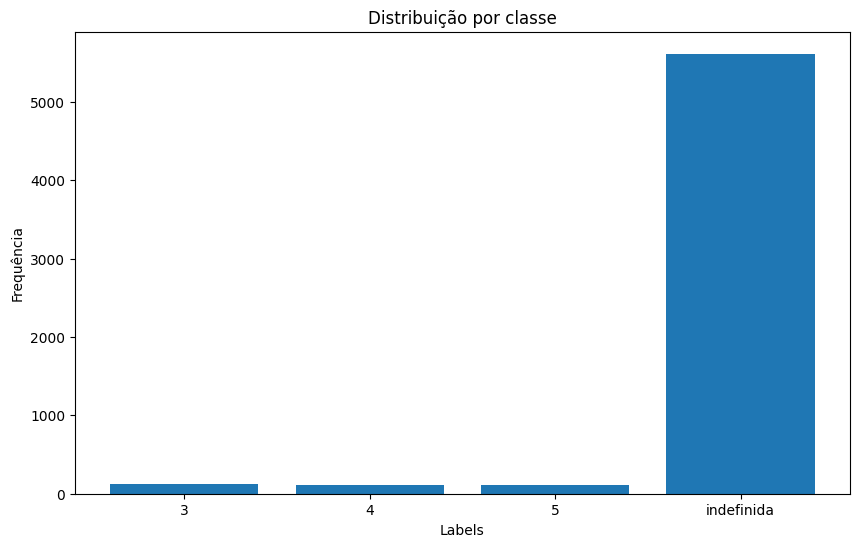

In [17]:
labels, counts = np.unique(np.array(y_train_final), return_counts=True)
labels = [str(i) for i in labels]

plt.figure(figsize=(10, 6))
plt.bar(labels, counts)
plt.xlabel('Labels')
plt.ylabel('Frequência')
plt.title('Distribuição por classe')
plt.show()

In [18]:
print(counts)

[ 120  116  116 5612]


Perceba que, mesmo após o aumento, o desbalanceamento de dados ainda é muito grande

# Treinamento do modelo

In [19]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers, models
from tensorflow.keras.utils import register_keras_serializable
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn import metrics
from tensorflow.keras import backend as K
from sklearn.metrics import confusion_matrix

2024-11-04 23:30:27.358768: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-04 23:30:27.479101: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-04 23:30:27.508808: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-04 23:30:27.730725: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-04 23:30:28.883641: W tensorflow/compiler/tf2

Usamos como função de custo a função focal loss, que foi desenvolvida para lidar com problemas de desbalanceamento de classes, pricipalmente em tarefas de detecção de objetos. 

Eu particluarmente não a conhecia, mas olhando o github de pessoas que trabalharam nesta mesma base, vi que ela teve melhores resultados que a função de entropia cruzada.

Se quiserem saber mais sobre esta função, o artigo original é [Focal Loss for Dense Object Detection](https://openaccess.thecvf.com/content_ICCV_2017/papers/Lin_Focal_Loss_for_ICCV_2017_paper).

In [20]:
@register_keras_serializable()
def focal_loss_fixed(y_true, y_pred, gamma=2.0, alpha=1.0):
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)
    y_true = tf.cast(y_true, tf.float32)

    alpha_t = y_true * alpha + (1 - y_true) * (1 - alpha)
    p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
    fl = -alpha_t * K.pow(1.0 - p_t, gamma) * K.log(p_t)
    return K.mean(fl)

@register_keras_serializable()
def focal_loss(gamma=2.0, alpha=1.0):
    def loss(y_true, y_pred):
        return focal_loss_fixed(y_true, y_pred, gamma=gamma, alpha=alpha)
    return loss

Como são muitos dados, não podemos processar todos de uma vez, além disso, eles são muito desbalanceados.
Para lidar com isso, vamos usar as seguintes técnicas:
* Data augmentation nas classes não majoritárias (já fizemos isso);
* Usar a focal loss como função de perda;
* Usar o One-sided Dynamic Undersampling (ODU).

O ODU é um método iterativo, originalmente proposto para classificação binária, onde cada iteração consiste em:
1. Usar o modelo para fazer predições em todo o conjunto de dados;
2. Selecionar as N amostras da classe majoritária que o modelo mais teve dificuldade de classificar, onde N é o número de amostras da classe minoritária;
3. Usar as N amostras selecionadas da classe majoritária e todas as amostras da classe minoritária para treinar o modelo;
4. Repetimos o processo com o modelo retreinado

O artigo original do ODU pode ser lido em [One-sided Dynamic Undersampling No-Propagation Neural Networks for imbalance problem](https://www.sciencedirect.com/science/article/pii/S0952197616300203).

Aqui precisamos adaptar o modelo para uma abordagem multiclasse. N será, então, o número de amostras da maior classe não majoritária. Além disso, na primeira iteração, selecionaremos N amsotras da classe majoritária de forma aleatória, pois o modelo não pode escolher antes de ser treinado.

In [1]:
# Seleão de amostras da classe majoritária de forma aleatória
def select_balanced_subset(x_train, y_train):
    # Conta a quantidade de amostras de cada classe
    unique_classes, class_counts = np.unique(y_train, return_counts=True)
    
    # Ordena as contagens de amostras por classe em ordem decrescente
    sorted_counts = np.sort(class_counts)[::-1]
    
    # Define n_minor como o número de amostras da classe minoritária mais frequente
    # (a segunda maior contagem de amostras)
    n_minor = sorted_counts[1] if len(sorted_counts) > 1 else sorted_counts[0]
    
    # Identifica a classe majoritária
    major_class = unique_classes[np.argmax(class_counts)]
    
    # Encontra os índices para a classe majoritária e as classes minoritárias
    major_indexes = [i for i, label in enumerate(y_train) if label == major_class]
    minor_indexes = [i for i, label in enumerate(y_train) if label != major_class]
    
    # Seleciona aleatoriamente n_minor amostras da classe majoritária
    selected_major_indexes = np.random.choice(major_indexes, n_minor, replace=False)
    
    # Combina as amostras selecionadas da classe majoritária com todas as amostras das classes minoritárias
    selected_indexes = np.concatenate([selected_major_indexes, minor_indexes])
    
    # Filtra x_train e y_train usando os índices selecionados
    x_train_final = x_train[selected_indexes]
    y_train_final = y_train[selected_indexes]
    
    return x_train_final, y_train_final

In [22]:
def ODU_multiclass(model, x_tr, y_tr, batch_size=2):
    # Divide x_tr em batches para evitar estouro de memória
    y_pred = []
    for i in range(0, len(x_tr), batch_size):
        batch_x = x_tr[i:i + batch_size]
        batch_pred = model.predict(batch_x, verbose=0)
        y_pred.extend(batch_pred)  # Adiciona as previsões ao array principal
    
    y_pred = np.array(y_pred)  # Converte a lista de previsões para um array numpy

    # Conta a quantidade de amostras de cada classe
    unique_classes, class_counts = np.unique(y_tr, return_counts=True)
    major_class = unique_classes[np.argmax(class_counts)]  # Classe majoritária
    major_class_index = np.argmax(class_counts) # índice da classe majoritária
    n_minor = np.max(class_counts)  # Tamanho da classe não majoritária mais frequente
    
    # Inicializa listas para índices da classe majoritária e minoritárias
    major_indexes = []
    minor_indexes = {class_label: [] for class_label in unique_classes if class_label != major_class}
    major_class_pred = []
    
    # Agrupa índices das classes majoritária e minoritárias
    for idx, prediction in enumerate(y_pred):
        if y_tr[idx] == major_class:
            major_class_pred.append(prediction[major_class_index])
            major_indexes.append(idx)
        else:
            minor_indexes[y_tr[idx]].append(idx)

    # Ordena os índices da classe majoritária de acordo com as probabilidades preditas
    major_indexes = [x for _, x in sorted(zip(major_class_pred, major_indexes))]
    
    # Seleciona o mesmo número de amostras da classe majoritária que a classe minoritária mais frequente
    selected_major_indexes = major_indexes[:n_minor]
    
    # Junta os índices das classes minoritárias e da amostra subamostrada da classe majoritária
    selected_indexes = selected_major_indexes + [idx for indices in minor_indexes.values() for idx in indices]
    
    # Seleciona as amostras e rótulos correspondentes
    new_x_tr = [x_tr[i] for i in selected_indexes]
    new_y_tr = [y_tr[i] for i in selected_indexes]
    
    return np.array(new_x_tr), np.array(new_y_tr)

Usamos um modelo EfficientNetB3 do keras, pretreinado no conjunto de dados ImageNet.

In [23]:
n_classes = len(np.unique(y_train_final))

base_model = keras.applications.EfficientNetB3(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3),
)

x = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation='softmax')(x)
model = keras.models.Model(inputs=[base_model.input], outputs=[output])
model.compile(optimizer='Adam', loss=focal_loss(), metrics=['accuracy'])

I0000 00:00:1730773829.896889   16306 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730773830.342164   16306 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730773830.342984   16306 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730773830.345265   16306 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

: 

Aqui é importante ressaltar que, como estamos lidando com um volume significativo de dados, precisamos usar um data loader, no caso a função `tf.data.Dataset.from_tensor_slices`. Ela divide o conjunto de treinamento em conjuntos menores (batches) e passa cada batch por vez ao modelo, evitando que ocupar excessivamente a memória RAM da GPU.

In [24]:
for i in range(50):
    if i == 0:
        # No primeiro passo, amostras selecionadas aleatoriamente
        x_train_balanced, y_train_balanced = select_balanced_subset(x_train_final, y_train_final)
    else:
        # Nos passos subsequentes, amostras selecionadas pelo método ODU_multiclass
        x_train_balanced, y_train_balanced = ODU_multiclass(model, x_train_final, x_train_final, batch_size=5)

    # Cria o dataset com balanceamento e aumento de desempenho
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train_balanced, pd.get_dummies(y_train_balanced)))
    train_dataset = train_dataset.shuffle(buffer_size=1000)  # Embaralha o dataset
    train_dataset = train_dataset.batch(16)                  # Aplica um batch
    train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)  # Otimiza a performance

    # Treina o modelo por 1 época usando o dataset balanceado
    model.fit(train_dataset, epochs=1)

#salvamos o modelo    
model.save("trained_model.keras")   

2024-11-04 23:30:32.989712: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 568393728 exceeds 10% of free system memory.
2024-11-04 23:30:33.113660: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 568393728 exceeds 10% of free system memory.
2024-11-04 23:30:33.187508: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 568393728 exceeds 10% of free system memory.
I0000 00:00:1730773862.454000   16403 service.cc:146] XLA service 0x7dd1f8001f70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730773862.454026   16403 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 SUPER, Compute Capability 7.5
2024-11-04 23:31:03.800707: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-04 23:31:08.070271: I external/local_xla/xla/stream_execu

 1/30 ━━━━━━━━━━━━━━━━━━━━ 41:02 85s/step - accuracy: 0.2500 - loss: 0.1964

I0000 00:00:1730773917.932736   16403 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


29/30 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.6179 - loss: 0.1332

E0000 00:00:1730773934.403813   16406 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1730773934.520953   16406 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


30/30 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - accuracy: 0.6262 - loss: 0.1307


In [ ]:
del x_train, x_train_augmented,	x_train_final, y_train,	y_train_augmented, y_train_final	
gc.collect()

18708

In [ ]:
# Esta linha existe caso o kernel pare. Dessa forma, não perdemos o modelo
model = tf.keras.models.load_model("trained_model.keras", custom_objects={'focal_loss_fixed': focal_loss_fixed, 'focal_loss': focal_loss})

In [ ]:
x_test = [basic_process(x) for x in x_test]
x_test = np.array(x_test)

In [ ]:
y_pred = []
for i in range(0, len(x_test), 10):
    batch_x = x_test[i:i + 10]
    batch_pred = model.predict(batch_x, verbose=0)
    y_pred.extend(batch_pred)  # Adiciona as previsões ao array principal
y_pred = np.array(y_pred)    

y_pred = pd.DataFrame(y_pred)
y_pred.columns = important_classes + ['indefinida']
y_pred = y_pred.idxmax(axis=1)

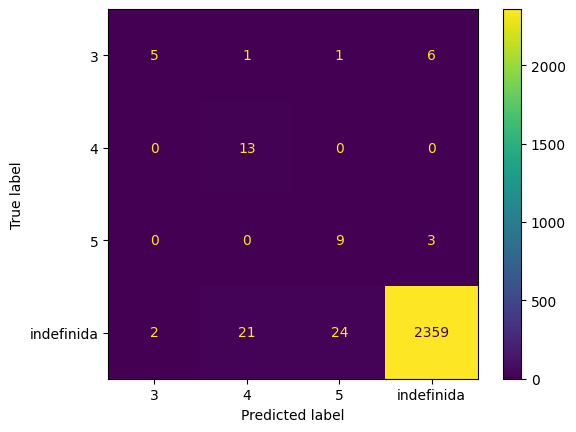

              precision    recall  f1-score   support

           3       0.71      0.38      0.50        13
           4       0.37      1.00      0.54        13
           5       0.26      0.75      0.39        12
  indefinida       1.00      0.98      0.99      2406

    accuracy                           0.98      2444
   macro avg       0.59      0.78      0.61      2444
weighted avg       0.99      0.98      0.98      2444



In [30]:
y_test = np.array(y_test).astype(str)
y_pred = y_pred.astype(str)
labels = np.array(important_classes + ['indefinida']).astype(str)

# Matriz de confusão
cf_matrix = confusion_matrix(y_test, y_pred, labels=labels)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=labels)
cm_display.plot()
plt.show()

# Relatório de classificação
relatorio = classification_report(y_test, y_pred, target_names=['3', '4', '5', 'indefinida'])
print(relatorio)

Gostaria de fazer algumas observações finais.
Primeiramente, tive muita dificuldade de reproduzir esse resultado (na verdade nem sequer conseguimos) devido à parada do kernel. Isso aconteceu, provavelmente devido ao uso da memória. O que me chamou mais atenção foi que o mesmo código foi executado, mesmo com algumas dificuldades (nem sempre o kernel foi colaborativo), há algumas horas atrás. De qualquer modo, a matriz de confusão e o relatório obtidos constituem o nosso reusltado.

Os resultados não foram muito ruins, mas também não foram bons. Algumas hipóteses podem nos ajudar a entender e melhorar o resultado obtido:

1. **Possível sobreajuste aos dados das classes não majoritárias:** Observe que, durante a aplicação do método ODU, as amostras da classe majoritária mudaram em cada iteração, enquanto que as amostras das classes minoritárias se mantiveram fixas. Isso pode ter levado o modelo a se sobreajustar aos dados das classes não majoritárias, não conseguindo generalizar no conjunto de teste;

2. **Alta incerteza não garante diversidade:** As amostras selecionadas pelo ODU não são necessáriamente diversas, ou seja, podemos ter amostras de poucas (ou até uma) classe. Dessa forma, classes pouco frequentes (ou inéditas) ao modelo podem possuir alta incerteza, mas não tanto a ponto de serem selecionadas. Isso pode fazer com que o modelo tenha dificulade ao identificar elementos de tais classes. Uma solução para isso, que foi implementada, mas não executada com sucesso (o kernel não ajudou), seria selecionar as amostras com maior incerteza de cada classe rotulada como 'indefinida'. Em se tratando de aprendizado supervisionado, não estou certo de quanto a falta de diversidade pode ser um problema. No entanto, em outros métodos de seleção de imagens (como active learning), isso pode ser um problema. Um paper que mostra bem isso é o [Active Learning for Single-Stage Object Detection in UAV Images](https://openaccess.thecvf.com/content/WACV2024/papers/Yamani_Active_Learning_for_Single-Stage_Object_Detection_in_UAV_Images_WACV_2024_paper.pdf);

3. **Uso de poucas imagens:** Caso recurso computacional estivesse disponível, seria interessante treinar o modelo com um número maior de imagens 'indefinidas', que poderia ser substancialmente maior que N. Poderíamos tratar o desequilibrio de classes (que certamente seria bem menor do que o que temos agora) com uma métrica adequada, e.g. F1-socre (macro). Além disso, aumentar ainda mais o número de imagens das classes não majoritárias via data augmentation também seria uma possibilidade.